In [1]:
import numpy as np
from matplotlib import pyplot as plt

import data_utils
from tsne import getScaledTsneEmbedding

from mdp import MDP
from env import Env
from q_learning import QLearningAlgo
from rewards import reward_func_simple_decay
from policy import EpsilonGreedyPolicy, GreedyPolicy, AlwaysDoPolicy, RandomPolicy

Using TensorFlow backend.


In [2]:
data = data_utils.Data()

100%|██████████| 53/53 [00:24<00:00,  1.62it/s]


In [3]:
mdp = MDP(data = data)

In [4]:
def reward_func_conf(stats):
    mean_conf_gender, mean_conf_age, mean_entropy_change_gender, mean_entropy_change_age, dev_conf_gender, dev_conf_age, dev_entropy_change_gender, dev_entropy_change_age = stats

    # Params: action -> 0 or 1, states -> State objects
    def func(prev_state, action, state):
        c_g = state.latest_confidence('gender')
        c_a = state.latest_confidence('age')

        cost = action * .8
        reward_conf = action * .5 * (((c_g - mean_conf_gender ) / dev_conf_gender) + 1) + \
                      action * .5 * (((c_a - mean_conf_age ) / dev_conf_age) + 1)
        
        return reward_conf - cost 

    return func


In [5]:
reward_func = reward_func_simple_decay(data.statistics) #reward_func_conf(data.statistics)

In [12]:
from tqdm import tqdm

mdp.set_mode('train')
mdp.reset()

policy = RandomPolicy(action_space = mdp.action_space)
# policy = AlwaysDoPolicy(action_space = mdp.action_space)

statevec = []
rconf = []
trackdict = {}

for i in tqdm(range(mdp.data.size())):
    action = policy.sample()
    prev_state, action, state = mdp.doAction(action)
    reward_conf = reward_func(prev_state, action)
    rconf.append(reward_conf)
    statevec.append(np.squeeze(state.vectorize()))
    if mdp.is_terminal:
        trackdict[mdp.dataiter.key] = (rconf, statevec)
        rconf = []
        statevec = []
        mdp.reset()


100%|██████████| 43010/43010 [00:04<00:00, 9872.02it/s] 


In [13]:
# Prepare data for tsne
keys = []
rewards = []
statevec = []
for key, value in tqdm(trackdict.items()):
    rconf, svec = value
    statevec.extend(svec)
    rewards.extend(rconf)
    keys.extend([key for _ in rconf])

100%|██████████| 841/841 [00:00<00:00, 54903.03it/s]


In [14]:
embeddings = getScaledTsneEmbedding(np.array(statevec), 50, 2000)
np.save('embeddings.npy',embeddings)
np.save('embedding_keys.npy',np.array(keys))
np.save('embedding_shades.npy',np.array(rewards))
# embeddings = np.load('embeddings.npy')
# keys = np.load('embedding_keys.npy')
# rewards = np.load('embedding_shades.npy')

In [15]:
keys = [hash(tuple(key)) for key in keys]
rewards = rewards / np.linalg.norm(rewards)

In [16]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']

Simple check for np.unique : True


/Users/yoelmolinas/anaconda3/envs/eyetracking/lib/python3.6/site-packages/matplotlib/collections.py:874: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


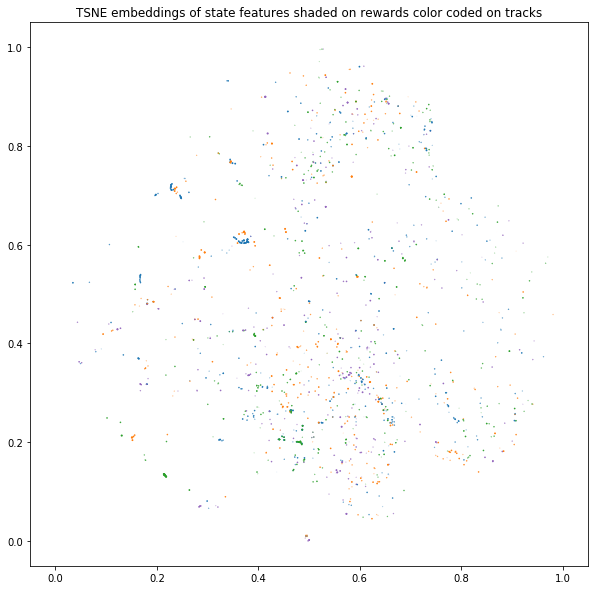

In [17]:
unique_keys, index, counts = np.unique(keys, return_counts = True, return_index=True)
print("Simple check for np.unique :", unique_keys[0] == keys[index[0]])
plt.figure(figsize=(10, 10))
plt.title("TSNE embeddings of state features shaded on rewards color coded on tracks")
for i, (key, idx, cnt) in enumerate(zip(unique_keys, index, counts)):
    c = colors[i%len(colors)]
    s = rewards[idx:idx+cnt]
    plt.scatter(embeddings[idx:idx+cnt, 0], embeddings[idx:idx+cnt, 1], c=c, s=s*100)
# plt.scatter(embeddings[:, 0], embeddings[:, 1], c='tab:green',s=rewards * 50)